## Import python module

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation

import h5py
import pickle
import os
import glob
import cv2 as cv 

## Import icewave module

In [4]:
# auto reload modules 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Users/sebas/git')

import icewave.tools.matlab2python as mat2py
import icewave.tools.matlab_colormaps as matcmaps
import icewave.sebastien.set_graphs as set_graphs
import icewave.tools.Fourier_tools as FT

# PARULA COLORMAP 
parula_map = matcmaps.parula()

plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions 

In [5]:
def get_laser_indices(img,threshold,channel_color):
    """ Get idx_start and idx_end, indices of columns over which we are looking for the laser
    Inputs : - img, image [ny,nx,3]
             - threshold, float, threshold used to binarize image
             - channel_color, 0,1 or 2, channel over which we perform thresholding 0 = R, 1 = G, 2 = B 
    Outputs : idx_start and idx_end, indices of column between which we are looking for the laser """
    
    mask = img[:,:,channel_color] > threshold

    # compute sum along raws
    sum_mask = np.sum(mask,axis = 0)
    # get minimal and maximal index between which we perform correlation 
    laser_indices = np.where(sum_mask > 0)[0]
    idx_start = laser_indices[0]
    idx_end = laser_indices[-1]
    return idx_start,idx_end

def subpix_precision(profile, idx_max):
    """ Computes the subpixel precision of a position in the convolution product 
    cf thesis manuscript Antonin Marchand """
    
    p = profile[idx_max]
    p_right = profile[idx_max + 1]
    p_left = profile[idx_max - 1]

    delta = (p_right - p_left)/(2*(2*p - p_right - p_left))
    i_subpix = idx_max + delta # subpixel index 
    
    max_subpix = p + 0.5*(2*p - p_right - p_left)*delta**2 # max value at the subpixel idx_max
    
    return i_subpix,max_subpix


def img_correlation_along_axis(M,analysis,axis = 0):
    """ Compute correlation between each column of a 2D matrix and an analysis function. 
    An image is built from the analysis function (using np.tile) in order to perform correlation 
    
    Inputs : - M, numpy array, [ny,nx]
             - analysis, 1D numpy array, analysis function [N]
             - axis, int, to define on which axes correlations must be performed
             
    Outputs : - correlated, numpy array [ny,nx] containing convolution result"""
    
    reps = (M.shape[1],1)
    analysis_matrix = np.tile(analysis,reps)
    
    correlated = scipy.signal.fftconvolve(M,analysis_matrix.T,mode = 'same',axes = axis)
    return correlated

def extract_laser_frame(M,analysis):
    """ Extract laser for a single frame 
    Inputs : - M, numpy array [ny,nx], matrix from which laser position should be extracted
             - analysis, 1D numpy array, analysis function [N] 
             
    Outpouts : - laser_profile, numpy array shape (nx,), containing subpix positions of the laser """

    correlated = img_correlation_along_axis(M, analysis)
    
    laser_profile = np.zeros(correlated.shape[1])

    for j in range(correlated.shape[1]):
        # compute sub-pixel position 
        idx_max = np.argmax(correlated[:,j])
        idx_subpix,max_subpix = subpix_precision(correlated[:,j],idx_max)
        laser_profile[j] = idx_subpix
        
    return laser_profile

def scale_spatio(laser_spatio,theta_rad,facq_pix,facq_t,idx_start,idx_end):
    """ Scale spatio temporal extraction of laser 
    Inputs : - laser_spatio, numpy array [nx,nt], spatio temporal extraction of the laser
             - theta, float, laser angle to the vertical, in radians
             - facq_pix, float, spatial acquisition frequency, in pix/meter
             - facq_t, float, temporal acquisition frequency, in frame/seconds
             - idx_start and idx_end, column indices of the image between which we looked for the laser 
             
    Outputs : - data, dictionnary containing parameters and scalings but mainly the 3 main keys :
                  + spatio_scaled, numpy array [nx,nt], surface deformation spatio temporal
                  + x, 1D numpy array, x-coordinate
                  + t, 1D numpy array, time coordinate """

    # scaling 
    spatio_scaled = (laser_spatio - np.mean(laser_spatio))/np.tan(theta_rad)/facq_pix # deformation in meter 
    x = np.arange(spatio_scaled.shape[0])/facq_pix # x coordinate in meter
    t = np.arange(spatio_scaled.shape[1])/facq_t # time array in seconds 
    
    # structure data 
    data = {}
    data['spatio'] = spatio_scaled
    data['x'] = x
    data['t'] = t
    data['param'] = {}
    data['param']['idx_start'] = idx_start
    data['param']['idx_end'] = idx_end
    data['param']['theta'] = theta_rad
    
    data['SCALE'] = {}
    data['SCALE']['facq_t'] = facq_t
    data['SCALE']['facq_pix'] = facq_pix
    data['SCALE']['fx'] = 1/facq_pix
    data['SCALE']['units'] = {'facq_t':'frame/s','facq_pix':'pix/m','fx':'m/pix'}
    
    return data 

def single_experiment_extraction(path2img,table_param,results_folder):
    """ perform laser extraction for all frames of a single movie 
    Inputs :- path2img, string, path to all frames 
            - table_param, dictionnary containing all experimental parameters
            - results_folder, string, folder where results will be saved """
            
    # generate a suffixe for saving data 
    h = float(re.findall(r'e_(\d+\.\d+)mm',path2img)[0]) # frasil thickness
    f_ex = float(re.findall(r'(\d+\.\d+)Hz',path2img)[0]) # excitation_frequency 
    amplitude = float(re.findall(r'Hz_(\d+)mm',path2img)[0])
    
    # collect parameters for this experiment
    key = f'h_{h}mm_fex_{f_ex}Hz'
    theta = table_param[key]['theta']
    theta_rad = theta*np.pi/180
    facq_t = table_param[key]['facq_t']
    facq_pix = table_param[key]['facq_pix']
    
    suffixe = f'h_{h}_fex_{f_ex}_amp_{amplitude}mm'
    suffixe = suffixe.replace('.','p')
    
    # list of image 
    img_list = glob.glob(f'{path2img}Basler*.tiff')

    ###### Define section of image where laser will be extracted
    red_threshold = 120 # threshold for selection of idx_start and idx_end
    channel_color = 0
    file2load = img_list[0]
    img = cv.imread(file2load)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    idx_start,idx_end = get_laser_indices(img, red_threshold, channel_color)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axvline(idx_start)
    ax.axvline(idx_end)
    figname = f'{results_folder}Subimage_selection_{suffixe}'
    plt.savefig(figname + '.pdf', bbox_inches='tight')
    plt.savefig(figname + '.svg', bbox_inches='tight')
    plt.savefig(figname + '.png', bbox_inches='tight')
    
    plt.close(fig)
    
    ####### Loop over all images 
    laser_spatio = np.zeros((idx_end - idx_start,len(img_list)))
    
    gaussian_width = 12
    N = 10
    gaussian = scipy.signal.windows.gaussian(M = gaussian_width * N,std = gaussian_width)
    
    for idx_img in range(len(img_list)):
        
        file2load = img_list[idx_img]
        print(f'{file2load} loaded !')
        img = cv.imread(file2load)
        img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            
        img_laser = img[:,idx_start:idx_end,:]
    
        laser_profile = extract_laser_frame(img_laser[:,:,0],gaussian)
        laser_spatio[:,idx_img] = laser_profile

    file2save = f'{results_folder}unscaled_laser_{suffixe}.pkl'

    with open(file2save,'wb') as pf:
        pickle.dump(laser_spatio,pf)
        
    print('Unscaled data saved !')

    file2save = f'{results_folder}unscaled_laser_{suffixe}.pkl'
    with open(file2save,'rb') as pf:
        laser_spatio = pickle.load(pf)
        
    data = scale_spatio(laser_spatio,theta_rad,facq_pix,facq_t,idx_start,idx_end)

    data['h'] = h
    data['f_ex'] = f_ex    
    data['amplitude'] = amplitude

    file2save = f'{results_folder}scaled_laser_structure_{suffixe}.pkl'
    with open(file2save,'wb') as pf:
        pickle.dump(data,pf)
        
    print('Scaled data saved !')
    
    return 


## Load Image 

U:/Aurore_frasil/2024_07_10_e_2.5mm_laser\3.3Hz_15mm/


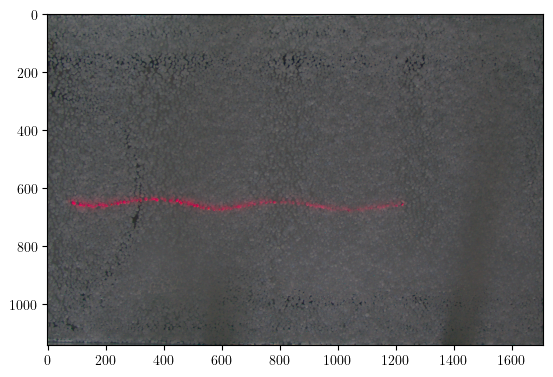

In [6]:
h = 2.5 # frasil thickness 
date = '2024_07_10'
path2data = f'U:/Aurore_frasil/{date}_e_{h}mm_laser/'

folderlist = glob.glob(f'{path2data}*mm')

# select an experiment
idx_folder = 3
path2img = f'{folderlist[idx_folder]}/'
print(path2img)
img_list = glob.glob(f'{path2img}Basler*.tiff')

idx_img = 300
file2load = img_list[idx_img]
img = cv.imread(file2load)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

fig,ax = plt.subplots()
ax.imshow(img)

## Detect xmin and xmax

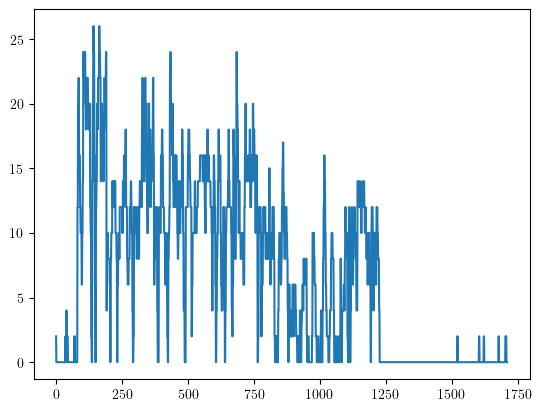

In [7]:
###### Define section of image where laser will be extracted
red_threshold = 120 # threshold for selection of idx_start and idx_end
channel_color = 0
file2load = img_list[0]
img = cv.imread(file2load)
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
idx_start,idx_end = get_laser_indices(img, red_threshold, channel_color)

mask = img[:,:,channel_color] > red_threshold

# compute sum along raws
sum_mask = np.sum(mask,axis = 0)
fig, ax = plt.subplots()
ax.plot(sum_mask)
# ax.set_ylim([0,10])

In [ ]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.axvline(idx_start)
ax.axvline(idx_end)
ax.set_xlim([idx_start,idx_end])
ax.set_ylim([600,700])

## Extract laser 

### Correlation with gaussian

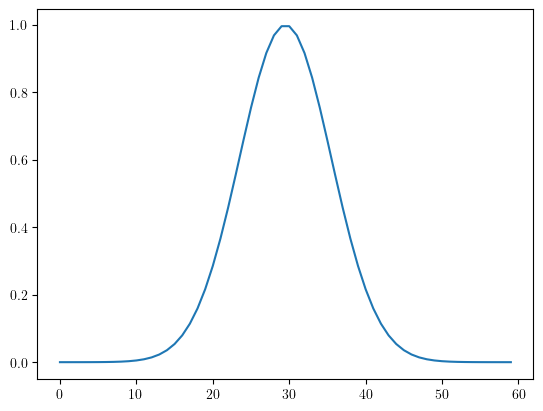

In [14]:
laser_spatio = np.zeros((idx_end - idx_start,len(img_list)))

gaussian_width = 6
N = 10
gaussian = scipy.signal.windows.gaussian(M = gaussian_width * N,std = gaussian_width)

fig, ax = plt.subplots()
ax.plot(gaussian)

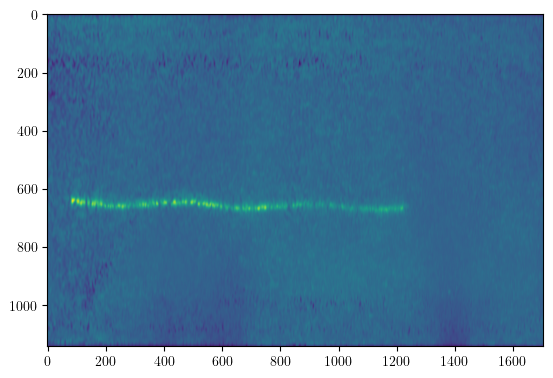

In [15]:
img_laser = img[:,idx_start:idx_end,:]
M = img_laser[:,:,0]
correlated = img_correlation_along_axis(M, gaussian)

fig, ax = plt.subplots()
ax.imshow(correlated)

### Find max subpixel along each column 

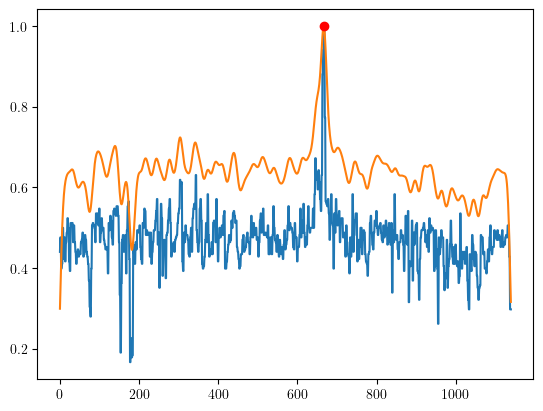

In [16]:
j = 700
idx_max = np.argmax(correlated[:,j])
idx_subpix,max_subpix = subpix_precision(correlated[:,j],idx_max)

fig, ax = plt.subplots()
ax.plot(M[:,j]/np.max(M[:,j]))
ax.plot(correlated[:,j]/correlated[:,j].max())
ax.plot(idx_subpix,max_subpix/correlated[:,j].max(),'ro')
# ax.set_xlim([idx_subpix - 100, idx_subpix + 100])

### Perform full extraction on a frame for different gaussians

In [12]:
# Scaling parameters
theta = 44.17 # laser angle to the vertical 
theta_rad = theta*np.pi/180 # angle in rad  
scale = 0.337 # scale in mm/pix
facq_pix = 1/(scale*1e-3) # scale in pixels / meter
# temporal scaling
facq_t =  67

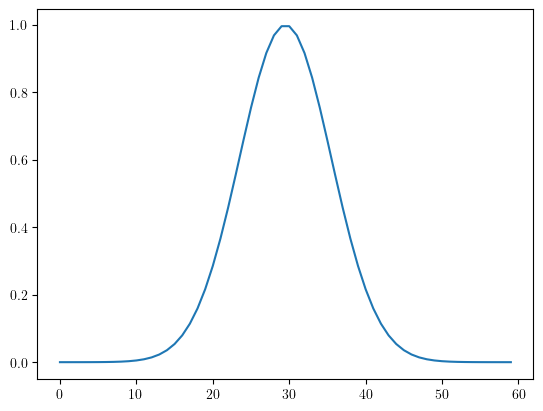

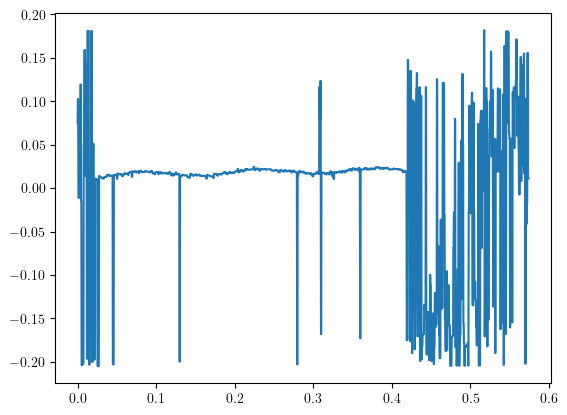

In [13]:
laser_spatio = np.zeros((idx_end - idx_start,len(img_list)))
gaussian_width = 6
N = 10
gaussian = scipy.signal.windows.gaussian(M = gaussian_width * N,std = gaussian_width)

fig, ax = plt.subplots()
ax.plot(gaussian)

laser_profile = extract_laser_frame(img_laser[:,:,0],gaussian)
laser_spatio[:,idx_img] = laser_profile

spatio_scaled = (laser_spatio[:,idx_img] - np.mean(laser_spatio[:,idx_img]))/np.tan(theta_rad)/facq_pix # deformation in meter 
x = np.arange(spatio_scaled.shape[0])/facq_pix # x coordinate in meter

fig, ax = plt.subplots()
ax.plot(x,spatio_scaled)
# ax.set_xlim([300,350])

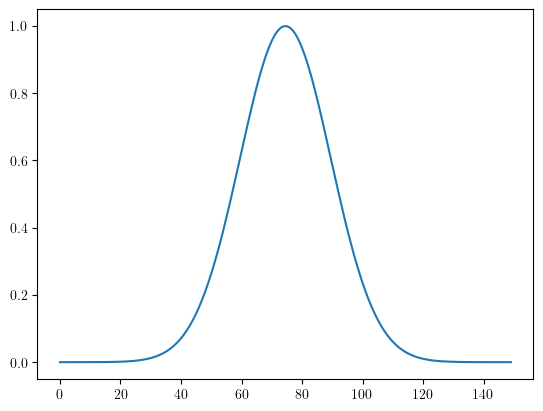

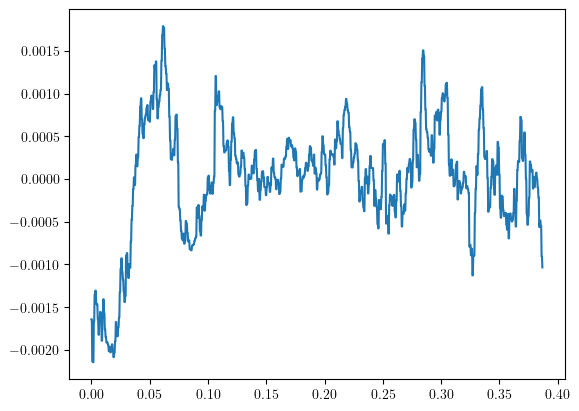

In [22]:
laser_spatio = np.zeros((idx_end - idx_start,len(img_list)))
gaussian_width = 15
N = 10
gaussian = scipy.signal.windows.gaussian(M = gaussian_width * N,std = gaussian_width)

fig, ax = plt.subplots()
ax.plot(gaussian)

laser_profile = extract_laser_frame(img_laser[:,:,0],gaussian)
laser_spatio[:,idx_img] = laser_profile

spatio_scaled = (laser_spatio[:,idx_img] - np.mean(laser_spatio[:,idx_img]))/np.tan(theta_rad)/facq_pix # deformation in meter 
x = np.arange(spatio_scaled.shape[0])/facq_pix # x coordinate in meter

fig, ax = plt.subplots()
ax.plot(x,spatio_scaled)
# ax.set_xlim([300,350])

## Perform laser extraction for all images

In [ ]:
h = 10 # frasil thickness 
date = '2024_07_11'
path2data = f'U:/Aurore_frasil/{date}_e_{h}mm_laser/'

folderlist = glob.glob(f'{path2data}*mm')

# select an experiment
idx_folder = 10
path2img = f'{folderlist[idx_folder]}/'
print(path2img)
img_list = glob.glob(f'{path2img}Basler*.tiff')

# create results folder 
results_folder = f'{path2data}Laser_extraction/'
if not os.path.isdir(results_folder) :
    os.mkdir(results_folder)
    
# load experimental parameters dictionnary
path2table = 'U:/Aurore_frasil/table_experimental_parameters.pkl'
with open(path2table,'rb') as pf :
    table_param = pickle.load(pf)

single_experiment_extraction(path2img,table_param,results_folder)
print(f'Laser extraction performed for {path2img}')


## Load data from laser extraction 

In [146]:
h = 10 # frasil thickness 
date = '2024_07_11'
path2data = f'U:/Aurore_frasil/{date}_e_{h}mm_laser/'

filelist = glob.glob(f'{path2data}Laser_extraction/scaled_laser_structure_*.pkl')

idx_experiment = 5
file2load = filelist[idx_experiment]
print(file2load)
with open(file2load,'rb') as pf:
    data = pickle.load(pf)

U:/Aurore_frasil/2024_07_11_e_10mm_laser/Laser_extraction\scaled_laser_structure_h_10p0_fex_3p5_amp_15p0mm.pkl


In [135]:
data.keys()


dict_keys(['spatio', 'x', 't', 'param', 'SCALE', 'h', 'f_ex', 'amplitude'])

Text(0, 0.5, '$\\xi \\; \\mathrm{(mm)}$')

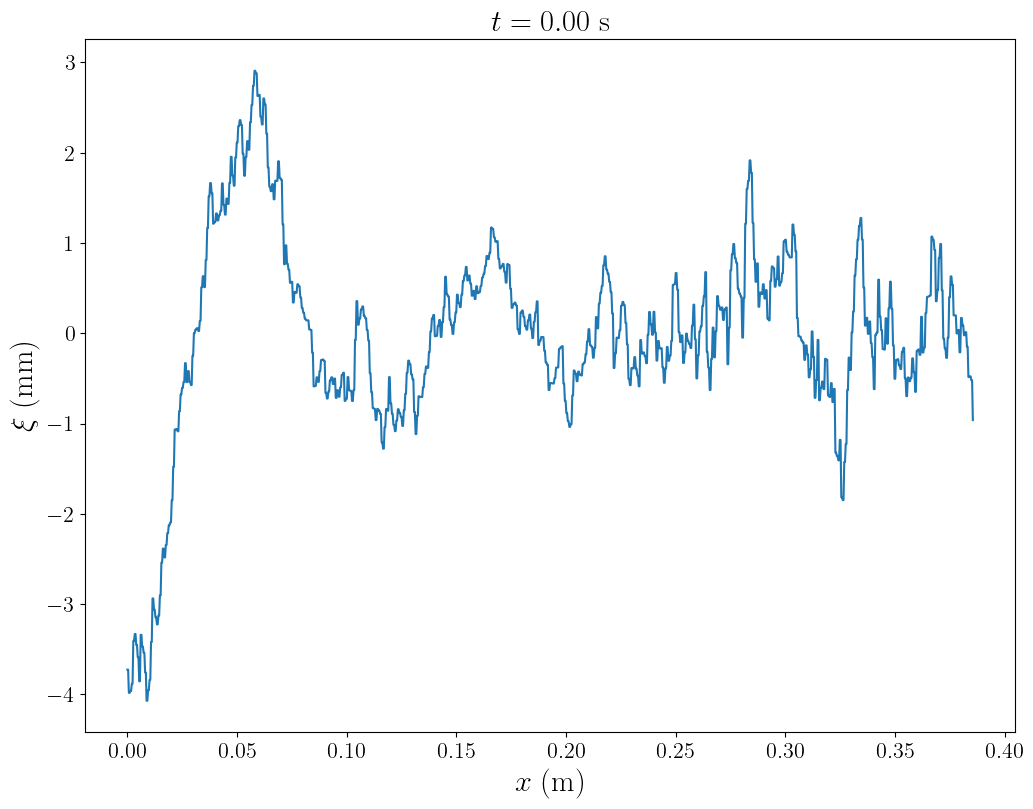

In [142]:
set_graphs.set_matplotlib_param('single')
fig, ax = plt.subplots(figsize = (12,9))
j0 = 0 # initial time index 
line = ax.plot(data['x'],data['spatio'][:,j0]*1e3)[0]
t = data['t']

ax.set_title(r'$t =' + '{:.2f}'.format(t[j0]) + r' \; \mathrm{s}$')
ax.set_xlabel(r'$x \; \mathrm{(m)}$',labelpad = 5)
ax.set_ylabel(r'$\xi \; \mathrm{(mm)}$',labelpad = 5)

In [144]:
def animation_profile(data,x,t,nb_frames,time_interval):
    
    """ Create and return animation of a line plot using matplotlib.animation
    Inputs : - fig: matplotlib figure
         - ax: axis object
         - data: numpy array, data to plot #dim0 : space, #dim1 : time
         - x: numpy array, x-axis (space)
         - t: numpy array, (time)
         - nb_frames : int, number of frames to show
         - time_interval : time between two consecutive frames
         
    Output : - ani: matplotlib animation object"""
    
    set_graphs.set_matplotlib_param('single')
    fig, ax = plt.subplots(figsize = (12,9))
    j0 = 0 # initial time index 
    line = ax.plot(x,data[:,j0])[0]
    
    ax.set_title(r'$t =' + '{:.2f}'.format(t[j0]) + r' \; \mathrm{s}$')
    ax.set_xlabel(r'$x \; \mathrm{(m)}$',labelpad = 5)
    ax.set_ylabel(r'$\xi \; \mathrm{(mm)}$',labelpad = 5)
    
    # small function to update the current figure 
    def update_profile_plot(frame):
        line.set_xdata(x)
        line.set_ydata(data[:,frame])
        ax.set_title(r'$t =' + '{:.2f}'.format(t[frame]) + r' \; \mathrm{s}$')
        return line
    
    # create an animation 
    ani = animation.FuncAnimation(fig=fig, func=update_profile_plot, frames=nb_frames, interval=time_interval)
    plt.show()
    print('Animation computed')
    
    return ani

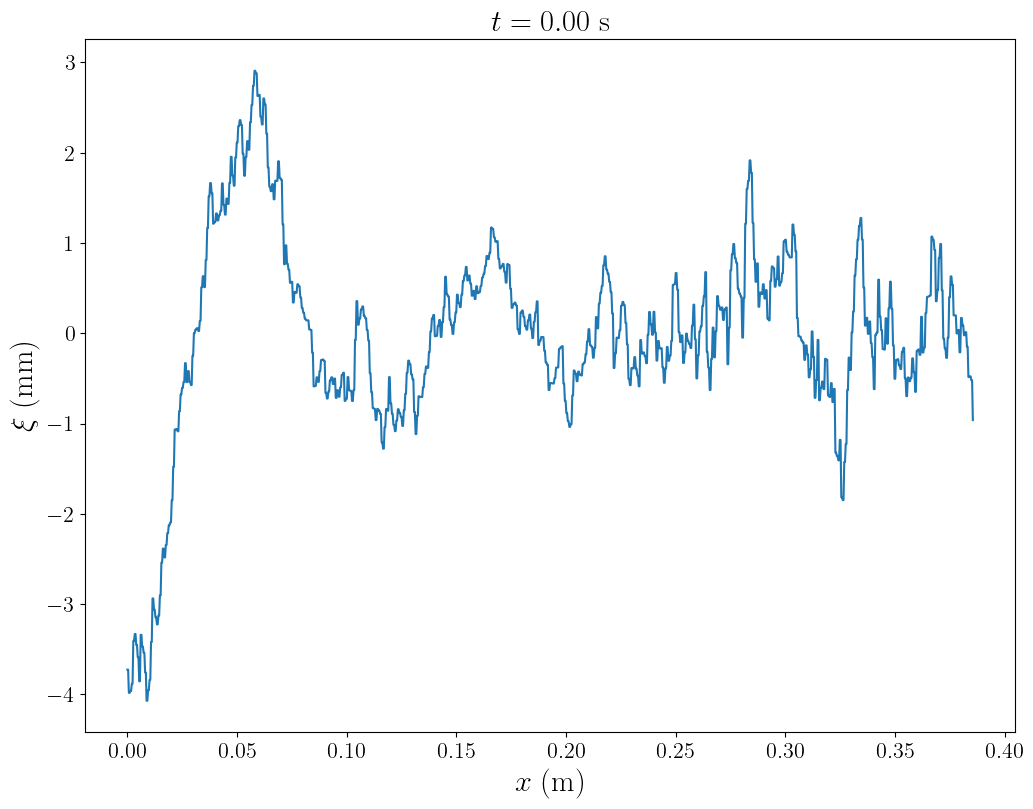

Animation computed


KeyboardInterrupt: 

In [147]:
nb_frames = len(data['t'])
ani = animation_profile(data['spatio']*1e3,data['x'],data['t'],nb_frames,time_interval = 1e3)

file2save = f'{path2data}Laser_extraction/animation_test.mp4'
print('Saving animation...')
ani.save(file2save)
print('Animation saved')

{'spatio': array([[-3.72527577e-03, -3.75642290e-03, -2.75964936e-03, ...,
        -1.64939281e-03, -1.49503869e-04,  9.63926095e-04],
       [-3.72527577e-03, -3.75642290e-03, -2.75964936e-03, ...,
        -1.64939281e-03, -1.49503869e-04,  9.63926095e-04],
       [-3.98245126e-03, -3.98314352e-03, -3.13885477e-03, ...,
        -1.27133907e-03, -4.43418462e-05,  1.16160780e-03],
       ...,
       [-5.21222187e-04, -4.83212255e-04, -3.88876780e-04, ...,
        -7.66346764e-04, -9.15447647e-04, -1.05097657e-03],
       [-5.21222187e-04, -4.83212255e-04, -3.88876780e-04, ...,
        -7.66346764e-04, -9.15447647e-04, -1.05097657e-03],
       [-9.61577167e-04, -9.69541459e-04, -8.82725877e-04, ...,
        -1.09545288e-03, -1.39510243e-03, -1.52552256e-03]],
      shape=(1145, 1000)), 'x': array([0.00000e+00, 3.37000e-04, 6.74000e-04, ..., 3.84854e-01,
       3.85191e-01, 3.85528e-01], shape=(1145,)), 't': array([ 0.        ,  0.02687089,  0.05374177,  0.08061266,  0.10748354,
        0

## Load Aurore extraction 

In [126]:
path  = 'Y:/Banquise/Aurore/amplitude_vagues_laser/10mm/4.0Hz_15mm/'
file2load = f'{path}4.0Hz_15mm.pkl'

with open(file2load,'rb') as pf:
    Q = pickle.load(pf)

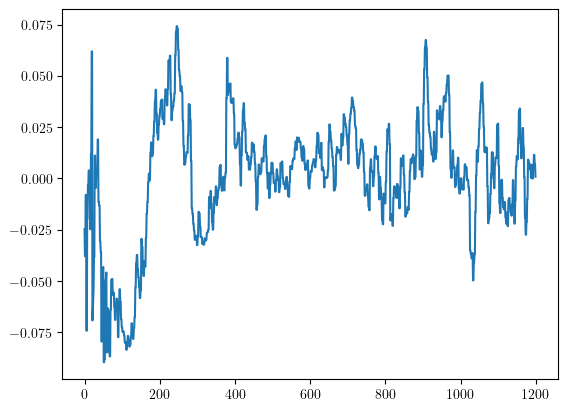

In [128]:
fig, ax = plt.subplots()
ax.plot(Q[:,0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.